# Detecting Weird Web Traffic
The goal for this project is to find anomalies in web traffic from different regions. Ideally the IT department would like to know when we're seeing spikes in data so they can preemptively deploy our web security team. They think that when the number of hits goes above 190 it might be a good indicator that something weird is happening

<p><strong>Goal</strong> - Detect anomalous web traffic</p>
<p><strong>Data</strong> - Web traffic by hosting region over time</p>
<p><strong>Task</strong> - Unsupervised anomaly detection</p>

# 1. Import Data

In [110]:
# %pip install gradio
%pip show gradio

Name: gradio
Version: 4.9.1
Summary: Python library for easily interacting with trained machine learning models
Home-page: 
Author: 
Author-email: Abubakar Abid <team@gradio.app>, Ali Abid <team@gradio.app>, Ali Abdalla <team@gradio.app>, Dawood Khan <team@gradio.app>, Ahsen Khaliq <team@gradio.app>, Pete Allen <team@gradio.app>, Ömer Faruk Özdemir <team@gradio.app>, Freddy A Boulton <team@gradio.app>
License: 
Location: /Users/valentinmonney/Desktop/Full Stack Machine Learning/fullstack/lib/python3.9/site-packages
Requires: aiofiles, altair, fastapi, ffmpy, gradio-client, httpx, huggingface-hub, importlib-resources, jinja2, markupsafe, matplotlib, numpy, orjson, packaging, pandas, pillow, pydantic, pydub, python-multipart, pyyaml, semantic-version, tomlkit, typer, typing-extensions, uvicorn
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [120]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import joblib
import gradio as gr

%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df

,Date,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6
0,1/1/2021,123.594462,179.799106,142.051377,165.898948,211.796438,140.574596
1,2/1/2021,96.913589,142.312297,98.873977,160.450595,126.403444,146.323197
2,3/1/2021,127.769080,205.521667,102.443675,127.585609,243.919837,211.321143
3,4/1/2021,232.383608,157.833057,151.695219,184.958764,112.802699,169.354083
4,5/1/2021,121.971639,166.400354,139.208040,105.576656,91.234096,221.821293
...,...,...,...,...,...,...,...
521,6/6/2022,217.863557,181.198188,39.779913,182.967647,214.980495,150.621250
522,7/6/2022,113.729390,77.027992,186.383935,132.213779,205.685236,152.728103
523,8/6/2022,180.824906,147.852357,206.998615,157.104039,177.652535,110.711463
524,9/6/2022,83.484784,41.622491,156.475805,171.243984,158.992203,136.988963


# 2. Analyse Train Set to Prevent Data Snooping Bias

In [4]:
train, test = train_test_split(df, test_size=0.3, random_state=1234)

In [5]:
train.shape

(368, 7)

In [6]:
test.shape

(158, 7)

In [7]:
train.head()

,Date,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6
436,13/3/2022,158.992329,103.595983,208.664219,128.352544,156.223776,262.221418
470,16/4/2022,148.618546,231.350464,782.000000,103.716711,158.796185,109.755732
521,6/6/2022,217.863557,181.198188,39.779913,182.967647,214.980495,150.621250
118,29/4/2021,164.808437,102.842019,53.699011,214.959871,44.470706,189.192559
162,12/6/2021,248.582870,130.898347,143.994442,96.685363,180.243516,165.263077


# 3. Exploratory Data Analysis

## Bird's Eye View

In [8]:
train.dtypes

Date         object
Region 1    float64
Region 2    float64
Region 3    float64
Region 4    float64
Region 5    float64
Region 6    float64
dtype: object

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 368 entries, 436 to 294
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      368 non-null    object 
 1   Region 1  368 non-null    float64
 2   Region 2  368 non-null    float64
 3   Region 3  368 non-null    float64
 4   Region 4  368 non-null    float64
 5   Region 5  368 non-null    float64
 6   Region 6  368 non-null    float64
dtypes: float64(6), object(1)
memory usage: 23.0+ KB


In [10]:
train.describe()

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6
count,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000
mean,151.128974,167.734819,155.862138,157.182245,161.480763,153.131734
std,51.369861,95.484190,80.129220,71.864944,91.850797,52.667582
min,11.184334,7.461471,-8.153494,-9.810526,-19.235141,-9.713714
25%,118.151654,126.804343,115.367657,121.458658,117.213061,119.523299
50%,150.579649,152.687679,147.487873,152.710155,151.404897,150.309562
75%,183.908133,192.515750,182.791165,188.930369,184.605039,185.003355
max,505.000000,784.000000,782.000000,723.000000,759.000000,404.000000


In [11]:
# check the 1.5 IQR for region 2
192.5+1.5*(192-126)

291.5

Its way under the max values. We will need to dig into these

In [12]:
# check the 1.5 IQR for region 4
188+1.5*(188-121)

288.5

## Plot Distributions

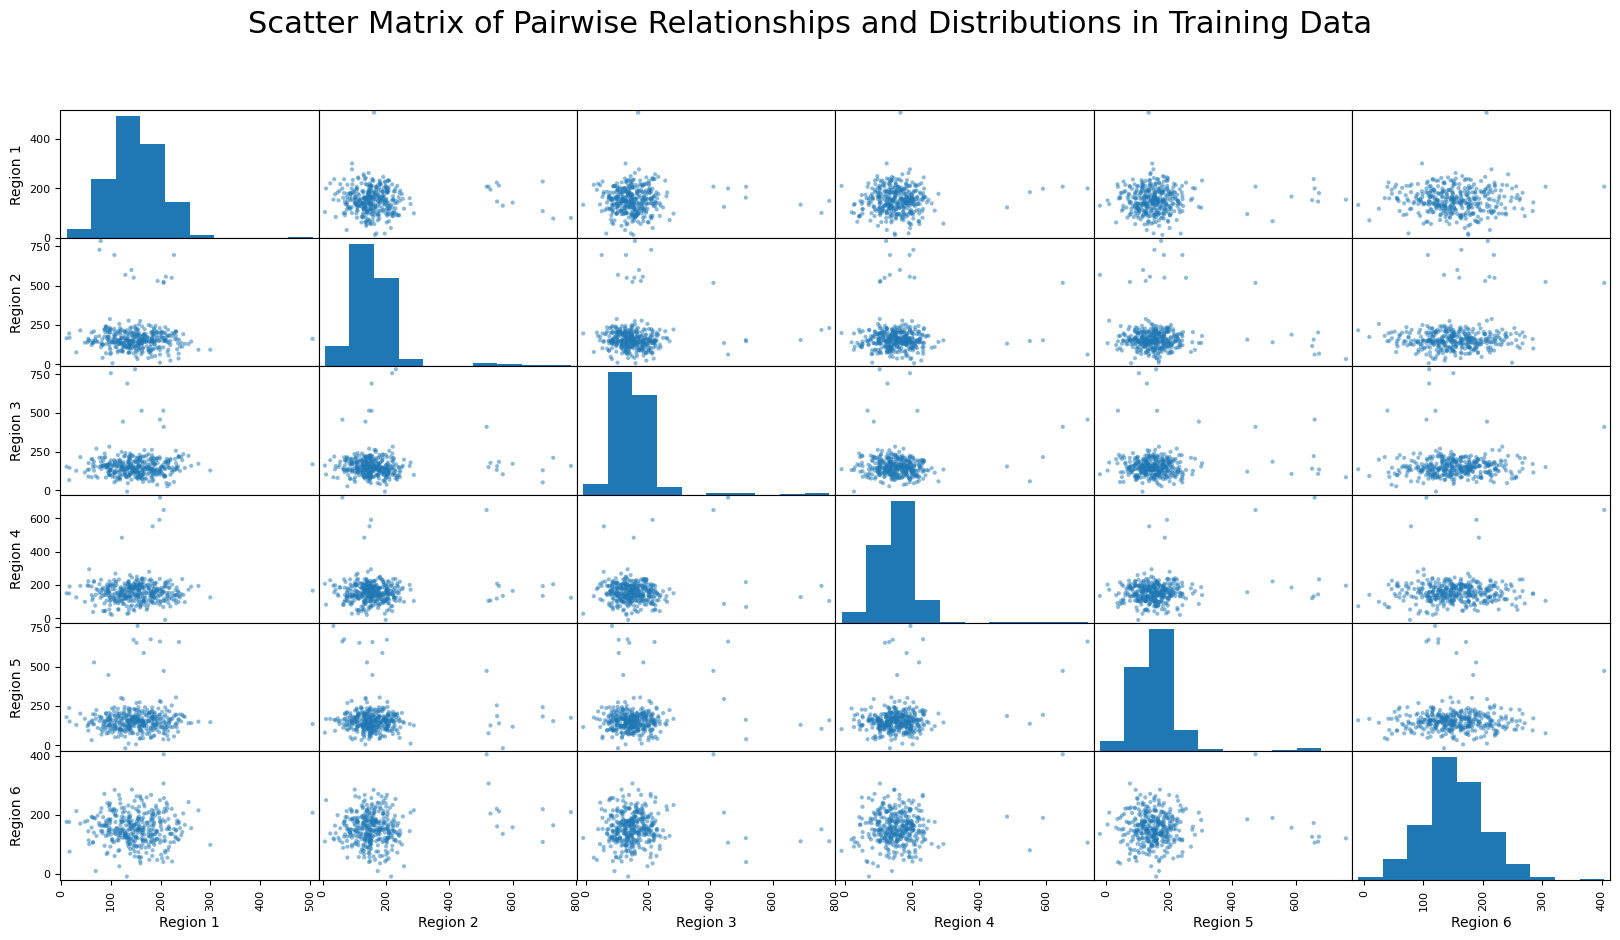

In [13]:
scatter_matrix(train, figsize=(20,10))
plt.suptitle("Scatter Matrix of Pairwise Relationships and Distributions in Training Data", fontsize=22)
plt.show()

## Fix Date Column to Be the appropriate Datatype

In [14]:
train['Date'] = pd.to_datetime(train['Date'], format="%d/%m/%Y")

In [15]:
train.dtypes

Date        datetime64[ns]
Region 1           float64
Region 2           float64
Region 3           float64
Region 4           float64
Region 5           float64
Region 6           float64
dtype: object

In [16]:
train.iloc[0].Date.is_month_end

False

## Can we visually see anomalies?

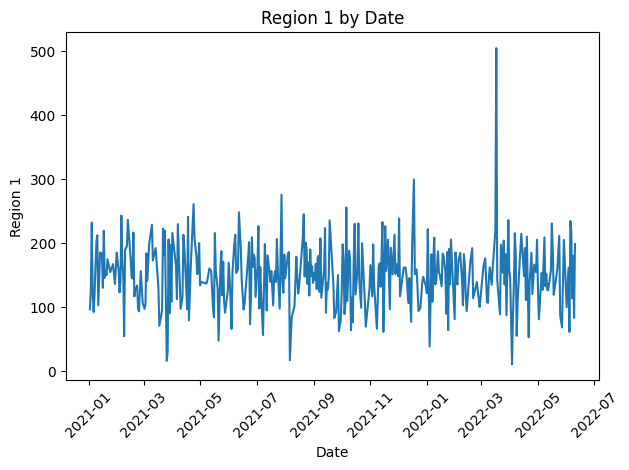

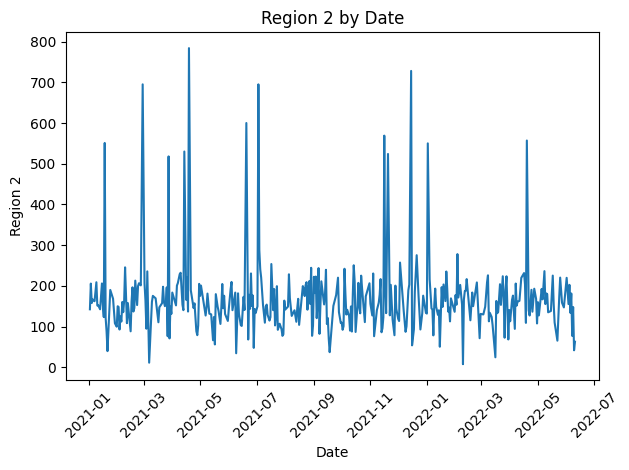

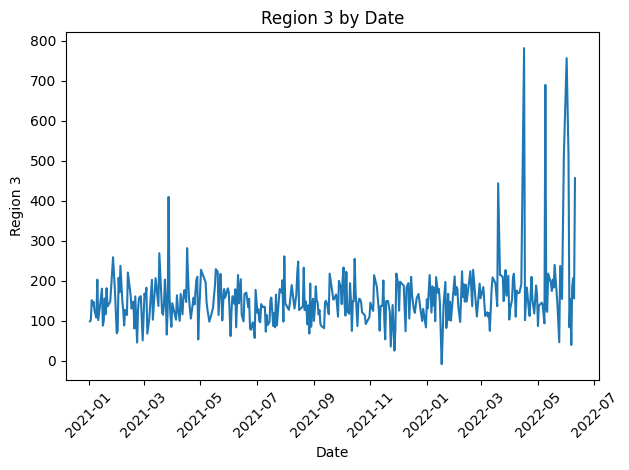

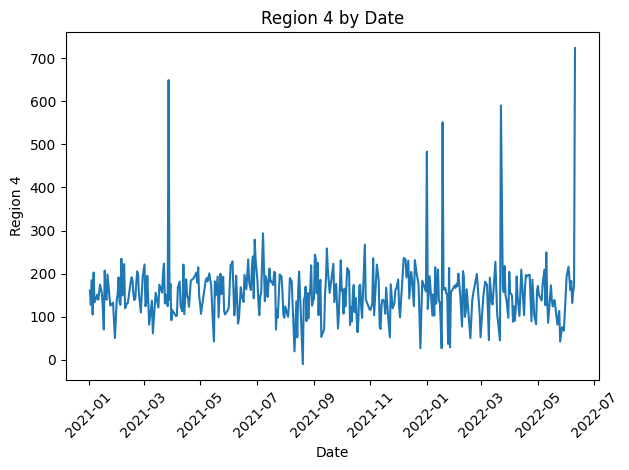

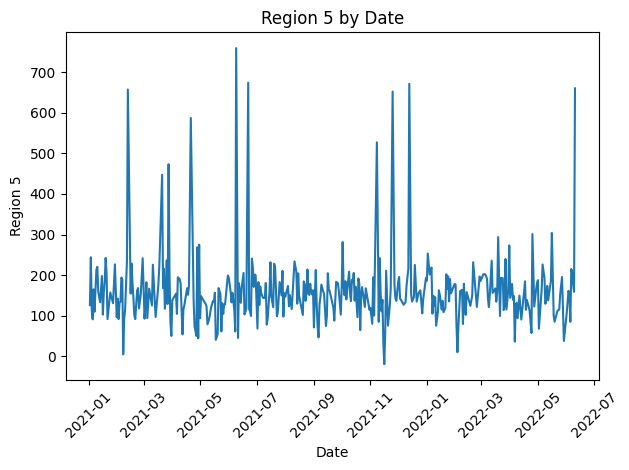

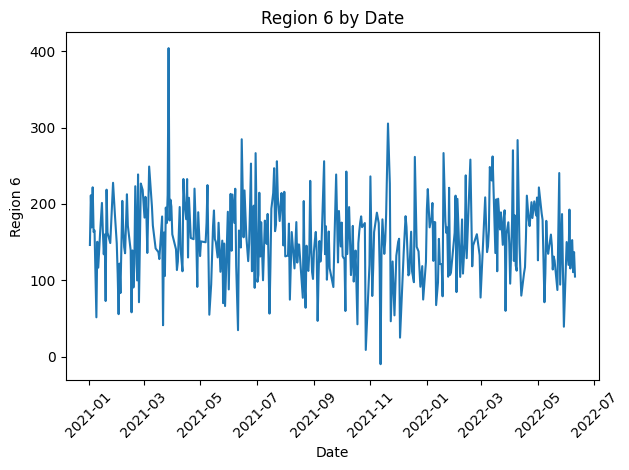

In [17]:
for col in train.columns[1:]:
    plt.title(f'{col} by Date')
    sns.lineplot(x='Date', y=col, data=train)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Do the Spikes have anything to do with time?

In [25]:
# Feature Engineering to create a spike feature
train['spike'] = (train[[col for col in train.columns if col.startswith('Region')]] >= 250).any(axis=1).astype(int)


In [26]:
train.head()

,Date,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,spike
436,2022-03-13,158.992329,103.595983,208.664219,128.352544,156.223776,262.221418,1
470,2022-04-16,148.618546,231.350464,782.000000,103.716711,158.796185,109.755732,1
521,2022-06-06,217.863557,181.198188,39.779913,182.967647,214.980495,150.621250,0
118,2021-04-29,164.808437,102.842019,53.699011,214.959871,44.470706,189.192559,0
162,2021-06-12,248.582870,130.898347,143.994442,96.685363,180.243516,165.263077,0


In [35]:
train['day'] = train['Date'].dt.dayofweek
train['month'] = train['Date'].dt.month
train['year'] = train['Date'].dt.year
train['monthstart'] = train['Date'].dt.is_month_start
train['monthend']= train['Date'].dt.is_month_end
train['quarterstart']= train['Date'].dt.is_quarter_start
train['quarterend']= train['Date'].dt.is_quarter_end

In [40]:
train[train['year']==2021]['month'].unique()

array([ 4,  6,  8, 11, 10, 12,  9,  7,  2,  5,  1,  3], dtype=int32)

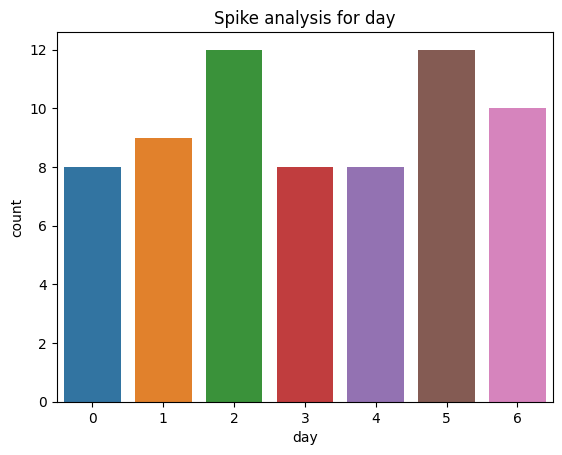

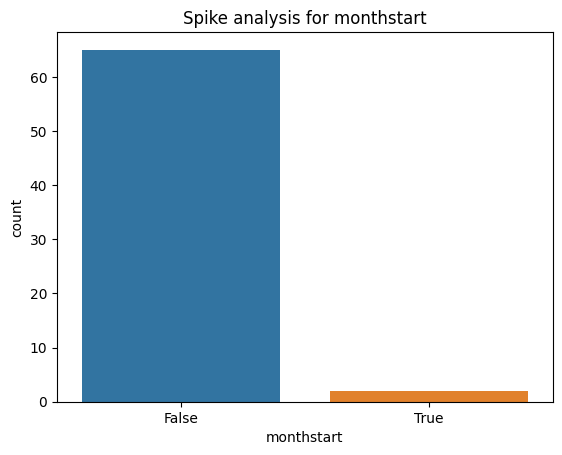

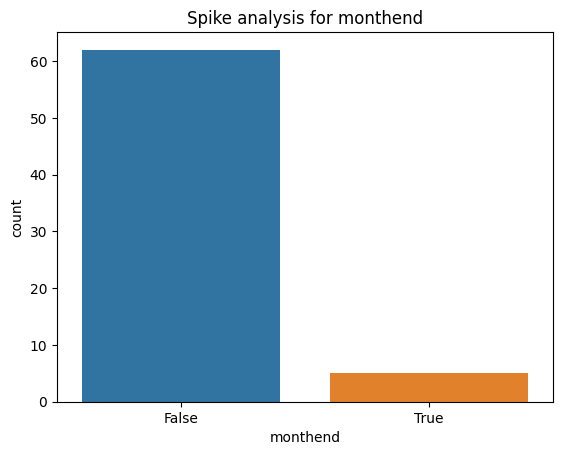

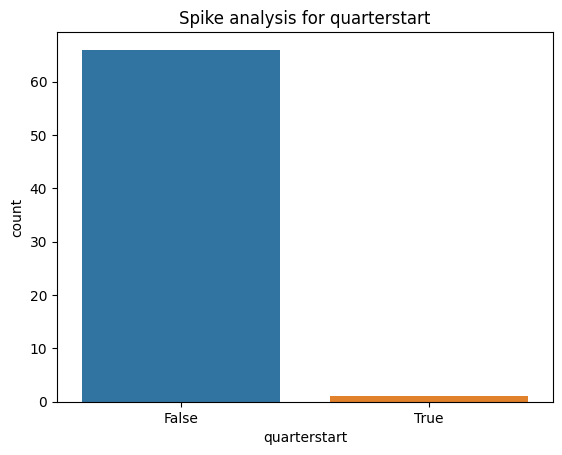

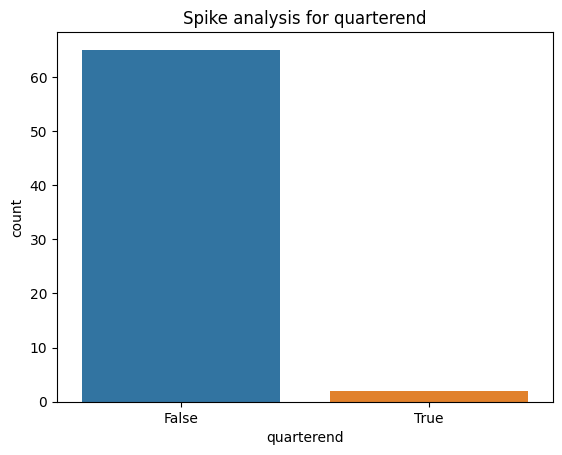

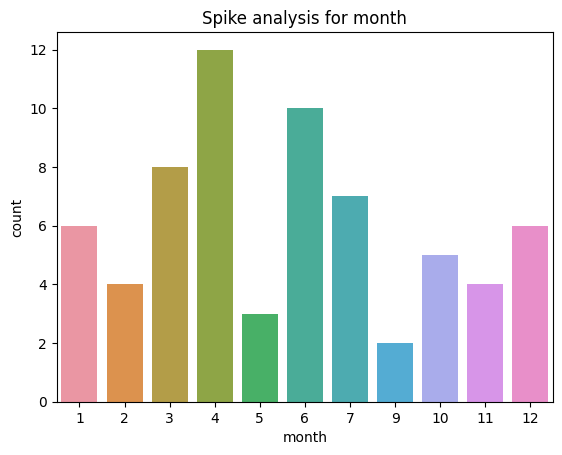

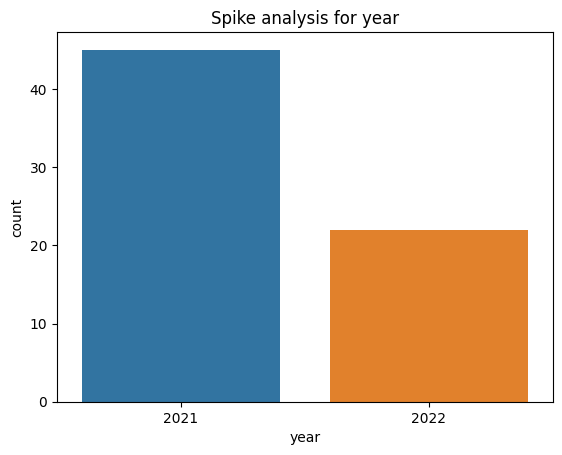

In [36]:
time_cols = ['day', 'monthstart', 'monthend','quarterstart', 'quarterend', 'month', 'year']
for col in time_cols:
    plt.title(f'Spike analysis for {col}')
    sns.countplot(x=col, data=train[train['spike']==1])
    plt.show()

In [41]:
train.drop(time_cols, axis=1, inplace=True)

In [42]:
train.head()

,Date,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,spike
436,2022-03-13,158.992329,103.595983,208.664219,128.352544,156.223776,262.221418,1
470,2022-04-16,148.618546,231.350464,782.000000,103.716711,158.796185,109.755732,1
521,2022-06-06,217.863557,181.198188,39.779913,182.967647,214.980495,150.621250,0
118,2021-04-29,164.808437,102.842019,53.699011,214.959871,44.470706,189.192559,0
162,2021-06-12,248.582870,130.898347,143.994442,96.685363,180.243516,165.263077,0


## Analyse Correlation

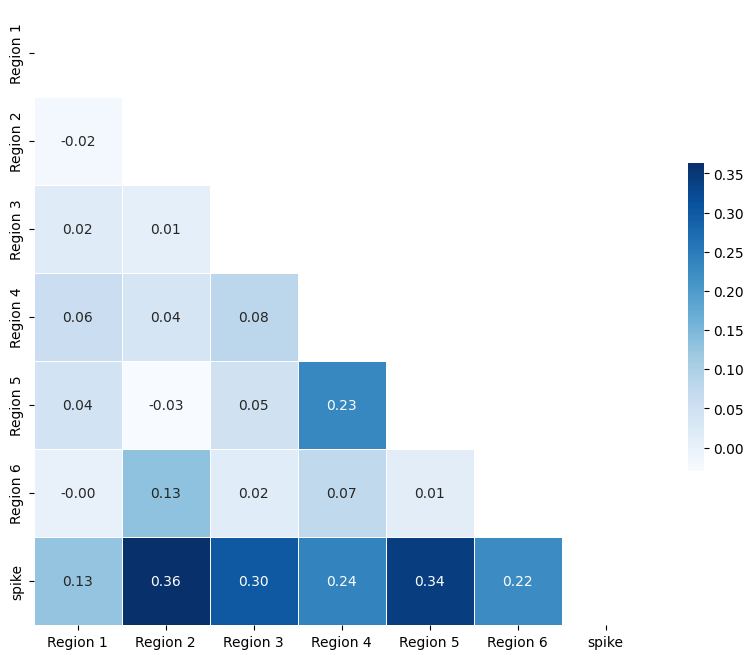

In [52]:
corr = train.select_dtypes(include='number').corr()


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))  # You can adjust the size as needed

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

# Show the plot
plt.show()

# 4. Data Preprocessing

## Drop Date and And Spike Col to Test Set

We drop spike column because we don't want to influence our model.
We also drop Date because it doesnt seem to give any relationship with those anomalies.

In [53]:
X_train = train.drop(['Date', 'spike'], axis=1)
X_test = test.drop('Date', axis=1)

In [54]:
X_train.head()

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6
436,158.992329,103.595983,208.664219,128.352544,156.223776,262.221418
470,148.618546,231.350464,782.000000,103.716711,158.796185,109.755732
521,217.863557,181.198188,39.779913,182.967647,214.980495,150.621250
118,164.808437,102.842019,53.699011,214.959871,44.470706,189.192559
162,248.582870,130.898347,143.994442,96.685363,180.243516,165.263077


In [55]:
X_test.head()

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6
261,174.982473,188.073353,212.564889,227.348706,90.856875,228.446842
425,155.830214,137.432916,165.569703,110.725701,123.453509,159.390772
21,116.924514,83.170321,83.832043,131.375901,213.164326,71.697156
329,189.518384,134.788869,161.219281,85.183524,124.251407,157.197199
310,136.550482,158.632527,234.408947,168.732082,173.253947,69.403637


# 5. Modelling

## Build ML Pipelines

In [62]:
pipelines = {
    "iso": make_pipeline(
        StandardScaler(), IsolationForest(n_estimators=300, random_state=1234)
    ),
    "lof": make_pipeline(
        StandardScaler(), LocalOutlierFactor(n_neighbors=20, novelty=True)
    ),
    "svm": make_pipeline(StandardScaler(), OneClassSVM()),
}

In [65]:
pipelines["iso"]

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('isolationforest',
                 IsolationForest(n_estimators=300, random_state=1234))])

## Train Models

In [67]:
fit_models = {}
for algo, model in pipelines.items():
    print(f"Commencing training for {algo}")
    model.fit(X_train)
    fit_models[algo] = model
    print(f"Completed training for {algo}")

Commencing training for iso
Completed training for iso
Commencing training for lof
Completed training for lof
Commencing training for svm
Completed training for svm


In [68]:
fit_models

{'iso': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('isolationforest',
                  IsolationForest(n_estimators=300, random_state=1234))]),
 'lof': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('localoutlierfactor', LocalOutlierFactor(novelty=True))]),
 'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('oneclasssvm', OneClassSVM())])}

# 6. Evaluate Models

## Create a Scoring Matrix For All Models

In [69]:
result_df = X_test.copy()
for algo, model in fit_models.items():
    res = model.predict(X_test)
    result_df[algo] = res

In [73]:
result_df[result_df["svm"] == -1]

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,iso,lof,svm
261,174.982473,188.073353,212.564889,227.348706,90.856875,228.446842,1,1,-1
21,116.924514,83.170321,83.832043,131.375901,213.164326,71.697156,1,1,-1
310,136.550482,158.632527,234.408947,168.732082,173.253947,69.403637,1,1,-1
66,89.879803,201.130424,134.432471,281.407783,159.461995,230.804372,1,1,-1
124,129.499511,462.000000,26.431366,162.445374,202.411825,157.847851,1,-1,-1
...,...,...,...,...,...,...,...,...,...
43,242.058629,156.975012,142.625262,130.416922,149.543268,174.722216,1,1,-1
115,145.231810,141.420973,218.935651,50.286454,138.589165,164.643271,1,1,-1
93,125.446549,45.943054,136.094739,148.353361,110.219904,215.959099,1,1,-1
362,142.876137,193.744128,111.953142,101.922023,263.122229,89.099177,1,1,-1


In [74]:
# Create the spike column
result_df["spike"] = (result_df[result_df.columns[0:6]] >= 250).any(axis=1).astype(int)
# Changing the results to look like the algos
result_df["spike"] = result_df["spike"].replace(1, -1).replace(0, 1)

In [78]:
result_df[result_df["svm"] == -1]

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,iso,lof,svm,spike
261,174.982473,188.073353,212.564889,227.348706,90.856875,228.446842,1,1,-1,1
21,116.924514,83.170321,83.832043,131.375901,213.164326,71.697156,1,1,-1,1
310,136.550482,158.632527,234.408947,168.732082,173.253947,69.403637,1,1,-1,1
66,89.879803,201.130424,134.432471,281.407783,159.461995,230.804372,1,1,-1,-1
124,129.499511,462.000000,26.431366,162.445374,202.411825,157.847851,1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...
43,242.058629,156.975012,142.625262,130.416922,149.543268,174.722216,1,1,-1,1
115,145.231810,141.420973,218.935651,50.286454,138.589165,164.643271,1,1,-1,1
93,125.446549,45.943054,136.094739,148.353361,110.219904,215.959099,1,1,-1,1
362,142.876137,193.744128,111.953142,101.922023,263.122229,89.099177,1,1,-1,-1


## Calculate Proxy Performance

In [98]:
# Create an empty dataframe
scores_df = pd.DataFrame()

for key in fit_models.keys():
    ytrue = result_df["spike"].replace(1, 0).replace(-1, 1)
    yhat = result_df[key].replace(1, 0).replace(-1, 1)
    precision = precision_score(ytrue, yhat)
    recall = recall_score(ytrue, yhat)
    f1 = f1_score(ytrue, yhat)

    # Append scores to the dataframe
    scores_df = pd.concat(
        [
            scores_df,
            pd.DataFrame(
                {
                    "Algorithm": [key],
                    "Precision": [precision],
                    "Recall": [recall],
                    "F1": [f1],
                }
            ),
        ],
        ignore_index=True,
    )

scores_df

,Algorithm,Precision,Recall,F1
0,iso,1.000000,0.304348,0.466667
1,lof,0.909091,0.434783,0.588235
2,svm,0.265823,0.913043,0.411765


In [99]:
ytrue = result_df["spike"]
yhat = result_df["lof"]

In [102]:
confusion_matrix(ytrue, yhat, labels=[-1, 1])

array([[ 10,  13],
       [  1, 134]])

## Make Predictions

In [106]:
fit_models["lof"].predict(X_test)

array([ 1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1])

## Save Models

In [108]:
joblib.dump(fit_models["lof"], "localoutlierfactor.joblib")

['localoutlierfactor.joblib']

# 7. Building a Gradio Checker APP

## Setup Gradio

In [115]:
def predict(region1, region2, region3, region4, region5, region6):
    model = joblib.load("localoutlierfactor.joblib")
    yhat = model.predict(
        np.array([[region1, region2, region3, region4, region5, region6]])
    )
    return "Weird Traffic" if yhat == -1 else "Normal Traffic"

In [116]:
X_test.iloc[0]

Region 1    174.982473
Region 2    188.073353
Region 3    212.564889
Region 4    227.348706
Region 5     90.856875
Region 6    228.446842
Name: 261, dtype: float64

In [118]:
X_test.iloc[0].tolist()

[174.9824725, 188.0733533, 212.5648887, 227.3487056, 90.85687477, 228.4468416]

In [119]:
predict(*X_test.iloc[0].tolist())

/Users/valentinmonney/Desktop/Full Stack Machine Learning/fullstack/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


'Normal Traffic'

## Build and Share Gradio App

In [134]:
app = gr.Interface(
    title="Traffic Anomaly Detection 🚦",
    fn=predict,
    inputs=[
        gr.Slider(0, 800),
        gr.Slider(0, 800),
        gr.Slider(0, 800),
        gr.Slider(0, 800),
        gr.Slider(0, 800),
        gr.Slider(0, 800),
    ],
    outputs="text",
)

In [135]:
app.launch(auth=("admin_user", "mySecretPa55w0rd"), share=True)

Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


In [136]:
app.close()

Closing server running on port: 7861
